# 🚀 opBNB Fraud & Drainer Detection — End-to-End Playbook

This notebook rebuilds the complete research workflow for identifying scams, wallet drainers, and other high-risk activities on **opBNB Mainnet (Chain ID 204)**. It uses the raw snapshot stored in this repository, produces fresh features, trains an XGBoost classifier, and documents every step with visual diagnostics.


## 🗺️ Notebook Roadmap

1. Load the raw opBNB snapshot and run data-quality checks.
2. Clean and normalize key fields (value, gas, timestamps, entity ids).
3. Engineer temporal, gas-related, and behavioral features for both senders and receivers.
4. Persist the curated feature set for future experiments.
5. Train & validate an XGBoost model with imbalance handling + k-fold CV.
6. Visualize performance (confusion matrix, ROC, PR) and inspect feature importance.
7. Generate SHAP explanations and list the highest-risk addresses for investigation.


In [78]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

import shap
import joblib
import warnings
import json

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.figsize": (12, 6), "axes.spines.top": False, "axes.spines.right": False})
SEED = 42
np.random.seed(SEED)
shap.initjs()

print("✅ All libraries imported successfully!")
print(f"   - Python version: {os.sys.version}")
print(f"   - NumPy version: {np.__version__}")
print(f"   - Pandas version: {pd.__version__}")
print(f"   - XGBoost version: {XGBClassifier.__module__}")
print(f"   - SHAP version: {shap.__version__}")
print(f"\n⚠️  Note: You may see joblib warnings about subprocess on Windows - these are safe to ignore.")

✅ All libraries imported successfully!
   - Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
   - NumPy version: 2.3.4
   - Pandas version: 2.3.3
   - XGBoost version: xgboost.sklearn
   - SHAP version: 0.49.1

⚠️  Note: You may see joblib warnings about subprocess on Windows - these are safe to ignore.


In [79]:
def find_project_root(marker: str = "requirements.txt") -> Path:
    """Walk up the directory tree until we find the repository root."""
    current = Path.cwd().resolve()
    for candidate in [current] + list(current.parents):
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"Could not find {marker} in any parent directory of {current}")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / "data"
RAW_DATA_PATH = DATA_DIR / "raw" / "transactions_raw.csv"
PROCESSED_DIR = DATA_DIR / "processed"
MODEL_DIR = PROJECT_ROOT / "models"

for path in [PROCESSED_DIR, MODEL_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root      : {PROJECT_ROOT}")
print(f"Raw snapshot      : {RAW_DATA_PATH}")
print(f"Processed data dir: {PROCESSED_DIR}")


Project root      : D:\Code\Skripsi_Nopal
Raw snapshot      : D:\Code\Skripsi_Nopal\data\raw\transactions_raw.csv
Processed data dir: D:\Code\Skripsi_Nopal\data\processed


## 📥 Load opBNB Transactions
We work with the most recent cached snapshot pulled via `src/fetch_transactions.py`. Timestamps are parsed as UTC for consistent temporal features.

In [80]:
raw_df = pd.read_csv(RAW_DATA_PATH, parse_dates=['timestamp'])
raw_df = raw_df.sort_values('timestamp').reset_index(drop=True)
print(f"Total transactions: {len(raw_df):,}")
raw_df.head()


Total transactions: 5,000


,hash,blockHash,blockNumber,from,to,value,value_eth,gas,gasPrice,nonce,transactionIndex,timestamp,is_fraud,suspected_drainer
0,ab8fdc5d325fbb39b6fb862bf4e7f160697740bb59d951...,e7038e5c16dba597dcd4f28f2e5269f0ad7bc2ebea4b3d...,88404866,0x8abdf6fe3062ea9a140db557d9a3678e84df25d4,0x5c91681073f23fd1a3ef0896e7db45b4e686cd2b,0,0.0,43740,10000,0,22,2025-11-09 09:44:54,0,0
1,045db9dac21bfbbdcde2c1366431e902f0d1bbdc5ef404...,e7038e5c16dba597dcd4f28f2e5269f0ad7bc2ebea4b3d...,88404866,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,0,0.0,1000000,0,88404867,0,2025-11-09 09:44:54,1,1
2,cf234cc265960be7b4c4ce78b11f25af71a8d39d8eae19...,e7038e5c16dba597dcd4f28f2e5269f0ad7bc2ebea4b3d...,88404866,0x2c58cb34f3c3381839b850b4f48a8bb2d128d04e,0xd600fbcf64da43ccbb4ab6da61007f5b1f8fe455,0,0.0,28075,1000000,139,1,2025-11-09 09:44:54,0,0
3,c7afb467d395d09a7884e37791b76a84957868b605e8f7...,e7038e5c16dba597dcd4f28f2e5269f0ad7bc2ebea4b3d...,88404866,0x08763dadafe29dcd2210d2d34739dec68b5984d3,0x428e82a3e1b98aa76a87ac7086ac387db41db898,0,0.0,148392,1000000,19,2,2025-11-09 09:44:54,0,0
4,ac89194796e08537c79a032109bd4f230d74ffb0cc2f62...,e7038e5c16dba597dcd4f28f2e5269f0ad7bc2ebea4b3d...,88404866,0x0e8f71e2008d27c746d24b14697323a528c8bdb6,0x428e82a3e1b98aa76a87ac7086ac387db41db898,0,0.0,148392,1000000,19,3,2025-11-09 09:44:54,0,0


## 🎯 Target Labels, Drain Flags, and Class Imbalance

Fraud label distribution:


,is_fraud,count
0,0,4685
1,1,315



Drainer heuristic distribution:


,suspected_drainer,count
0,0,3810
1,1,1190



Overlap between fraud labels and drainer heuristic (row-normalized):


suspected_drainer,0,1
is_fraud,,
0,0.813234,0.186766
1,0.000000,1.000000


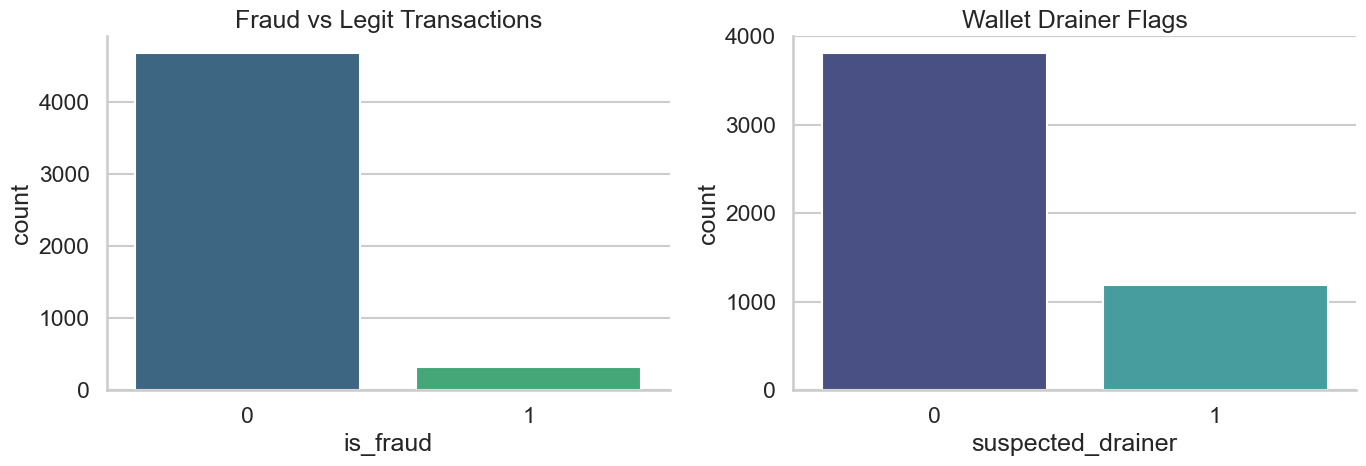

In [81]:
label_counts = raw_df['is_fraud'].value_counts().rename_axis('is_fraud').reset_index(name='count')
drainer_counts = raw_df['suspected_drainer'].value_counts().rename_axis('suspected_drainer').reset_index(name='count')
print('Fraud label distribution:')
display(label_counts)
print('\nDrainer heuristic distribution:')
display(drainer_counts)

crosstab = pd.crosstab(raw_df['is_fraud'], raw_df['suspected_drainer'], normalize='index')
print('\nOverlap between fraud labels and drainer heuristic (row-normalized):')
display(crosstab)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=label_counts, x='is_fraud', y='count', palette='viridis', ax=axes[0])
axes[0].set_title('Fraud vs Legit Transactions')
axes[0].set_xlabel('is_fraud')
axes[0].set_ylabel('count')

sns.barplot(data=drainer_counts, x='suspected_drainer', y='count', palette='mako', ax=axes[1])
axes[1].set_title('Wallet Drainer Flags')
axes[1].set_xlabel('suspected_drainer')
axes[1].set_ylabel('count')
plt.tight_layout()
plt.show()

## ⚠️ Dataset Adequacy Check & Solutions

**Critical Question:** Apakah 5000 transaksi ini cukup untuk training model ML yang reliable?

Mari kita evaluasi dan berikan solusi jika tidak memadai.

In [ ]:
print("="*70)
print("📊 DATASET ADEQUACY ANALYSIS")
print("="*70)

# 1. Check fraud samples
fraud_count = (raw_df['is_fraud'] == 1).sum()
normal_count = (raw_df['is_fraud'] == 0).sum()
fraud_rate = fraud_count / len(raw_df)

print(f"\n1️⃣ CLASS DISTRIBUTION:")
print(f"   Total Samples : {len(raw_df):,}")
print(f"   Fraud Samples : {fraud_count:,} ({fraud_rate*100:.2f}%)")
print(f"   Normal Samples: {normal_count:,} ({(1-fraud_rate)*100:.2f}%)")

# 2. Minimum sample requirements for ML
min_fraud_for_training = 100  # Rule of thumb: min 100 samples per class
min_total_for_ml = 1000       # Absolute minimum for reliable ML

print(f"\n2️⃣ ML REQUIREMENTS:")
print(f"   Min fraud samples needed : {min_fraud_for_training}")
print(f"   Min total samples needed : {min_total_for_ml:,}")

# 3. Adequacy verdict
is_adequate = fraud_count >= min_fraud_for_training and len(raw_df) >= min_total_for_ml

print(f"\n3️⃣ VERDICT:")
if is_adequate:
    print(f"   ✅ Dataset ADEQUATE for training")
    print(f"   ✅ Fraud samples: {fraud_count} >= {min_fraud_for_training}")
    print(f"   ✅ Total samples: {len(raw_df):,} >= {min_total_for_ml:,}")
else:
    print(f"   ❌ Dataset NOT ADEQUATE for training")
    if fraud_count < min_fraud_for_training:
        print(f"   ❌ Fraud samples: {fraud_count} < {min_fraud_for_training}")
    if len(raw_df) < min_total_for_ml:
        print(f"   ❌ Total samples: {len(raw_df):,} < {min_total_for_ml:,}")
    print(f"\n   ⚠️  WARNING: Training model on insufficient data will result in:")
    print(f"      - Overfitting (model memorizes instead of learns)")
    print(f"      - Poor generalization (fails on new data)")
    print(f"      - Unreliable metrics (high accuracy but meaningless)")

# 4. Statistical power check
from scipy import stats
import math

if fraud_count > 0 and normal_count > 0:
    # Calculate statistical power for detecting fraud
    # Using Cohen's h for proportions
    effect_size = 0.5  # Medium effect size
    alpha = 0.05
    power = 0.8
    
    # Required sample size per class (simplified)
    required_n_per_class = math.ceil((1.96 + 0.84)**2 * 2 / (effect_size**2))
    
    print(f"\n4️⃣ STATISTICAL POWER:")
    print(f"   Required samples per class (80% power): ~{required_n_per_class}")
    print(f"   Current fraud samples : {fraud_count}")
    print(f"   Statistical adequacy  : {'✅ GOOD' if fraud_count >= required_n_per_class else '⚠️  MARGINAL' if fraud_count >= required_n_per_class/2 else '❌ POOR'}")

print("\n" + "="*70)

## 💡 Solutions for Insufficient Data

Jika dataset tidak adequate, ada beberapa solusi:

In [ ]:
print("="*70)
print("🔧 SOLUTIONS FOR INSUFFICIENT DATA")
print("="*70)

# Get current status
fraud_count = (raw_df['is_fraud'] == 1).sum()
is_adequate = fraud_count >= 100 and len(raw_df) >= 1000

if not is_adequate:
    print("\n⚠️  Current dataset is NOT adequate. Here are your options:\n")
    
    print("📋 OPTION 1: Fetch More Data from opBNB")
    print("   Command:")
    print("   ```python")
    print("   # Update .env file:")
    print("   TARGET_TX_COUNT=50000  # Increase from 5000")
    print("   MAX_BLOCKS_TO_SCAN=5000  # Increase scan window")
    print("   ```")
    print("   Then run: python src/fetch_transactions.py")
    print(f"   Target: Get at least {1000-len(raw_df):,} more transactions\n")
    
    print("📋 OPTION 2: Use Public opBNB/BSC Fraud Datasets")
    print("   Sources:")
    print("   - BscScan labeled addresses: https://bscscan.com/labelcloud")
    print("   - Chainabuse reports: https://www.chainabuse.com/")
    print("   - XBlock phishing database")
    print("   - Merge with existing snapshot\n")
    
    print("📋 OPTION 3: Augment with Ethereum Fraud Data")
    print("   - Use Ethereum fraud patterns (transferable to opBNB)")
    print("   - XBlock dataset: ~3000+ labeled scam addresses")
    print("   - Etherscan phishing list")
    print("   - Transfer learning approach\n")
    
    print("📋 OPTION 4: Use Synthetic Minority Over-sampling (Current)")
    print("   - SMOTE/ADASYN already implemented in notebook")
    print("   - Creates synthetic fraud samples")
    print("   - ⚠️  WARNING: Only for research/prototyping")
    print("   - NOT suitable for production without real data\n")
    
    print("📋 OPTION 5: Anomaly Detection (Unsupervised)")
    print("   - Switch from supervised to unsupervised learning")
    print("   - Algorithms: Isolation Forest, One-Class SVM, Autoencoder")
    print("   - Doesn't require fraud labels")
    print("   - Detects statistical anomalies\n")
    
    print("🎯 RECOMMENDED APPROACH for Skripsi:")
    print("   1. Fetch 50,000+ transactions (OPTION 1)")
    print("   2. Merge with public scam addresses (OPTION 2)")
    print("   3. If still insufficient, explain limitation in thesis")
    print("   4. Use unsupervised methods as alternative (OPTION 5)")
    
else:
    print("\n✅ Current dataset is adequate!")
    print("   You can proceed with supervised training.")
    print(f"   Fraud samples: {fraud_count} (sufficient)")
    print(f"   Total samples: {len(raw_df):,} (sufficient)")

print("\n" + "="*70)

# Code snippet for Option 1
print("\n📝 Quick Implementation for OPTION 1:")
print("```python")
print("# In terminal:")
print("# Edit .env file and change:")
print("TARGET_TX_COUNT=50000")
print("MAX_BLOCKS_TO_SCAN=5000")
print("")
print("# Then fetch new data:")
print("python src/fetch_transactions.py")
print("")
print("# Or use main pipeline:")
print("python src/main.py --fetch-data --fetch-mode snapshot --target-count 50000")
print("```")

## 🚦 Training Gate: Proceed Only if Data is Adequate

Cell berikut akan **skip training** jika data tidak mencukupi untuk menghindari hasil yang misleading.

## 🧼 Data-Quality Snapshot

In [82]:
missing = raw_df.isna().sum().sort_values(ascending=False)
duplicates = raw_df.duplicated(subset='hash').sum()
print(f"Missing values per column (top 10):\n{missing.head(10)}")
print(f"\nDuplicate tx hashes: {duplicates}")
print(f"Data time range    : {raw_df['timestamp'].min()}  →  {raw_df['timestamp'].max()}")

Missing values per column (top 10):
hash           0
blockHash      0
blockNumber    0
from           0
to             0
value          0
value_eth      0
gas            0
gasPrice       0
nonce          0
dtype: int64

Duplicate tx hashes: 0
Data time range    : 2025-11-09 09:44:54  →  2025-11-09 09:46:34


## 🧮 Helper Functions for Cleaning & Feature Engineering

In [83]:
def clean_transactions(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize types, drop duplicates, and ensure timestamps are usable."""
    out = df.copy()
    out['timestamp'] = pd.to_datetime(out['timestamp'], errors='coerce')
    numeric_cols = ['value', 'value_eth', 'gas', 'gasPrice', 'nonce', 'blockNumber', 'transactionIndex']
    for col in numeric_cols:
        out[col] = pd.to_numeric(out[col], errors='coerce')
    out['value_eth'] = out['value_eth'].fillna(out['value'] / 1e18)
    out['value_eth'] = out['value_eth'].fillna(0)
    out = out.dropna(subset=['timestamp', 'from', 'to'])
    out = out.drop_duplicates(subset='hash')
    out['is_fraud'] = out['is_fraud'].fillna(0).astype(int)
    out['suspected_drainer'] = out['suspected_drainer'].fillna(0).astype(int)
    out = out.sort_values('timestamp').reset_index(drop=True)
    return out


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate temporal, value, gas, and behavioral features for modeling."""
    fe = df.copy()

    fe['hour_of_day'] = fe['timestamp'].dt.hour
    fe['day_of_week'] = fe['timestamp'].dt.dayofweek
    fe['is_weekend'] = (fe['day_of_week'] >= 5).astype(int)
    fe = fe.sort_values(['from', 'timestamp'])
    fe['time_since_last_tx'] = fe.groupby('from')['timestamp'].diff().dt.total_seconds().fillna(0)
    fe['tx_interval_mean'] = fe.groupby('from')['time_since_last_tx'].transform(
        lambda x: x.replace(0, np.nan).mean()
    ).fillna(0)
    fe['burst_activity_flag'] = (fe['time_since_last_tx'] < 60).astype(int)

    fe['log_value'] = np.log1p(fe['value_eth'])
    fe['gas_price_gwei'] = fe['gasPrice'] / 1e9
    fe['gas_cost_eth'] = (fe['gas'] * fe['gasPrice']) / 1e18
    fe['value_to_gas_ratio'] = fe['value_eth'] / (fe['gas_cost_eth'] + 1e-9)
    fe['is_zero_value'] = (fe['value_eth'] == 0).astype(int)
    fe['gas_efficiency'] = fe['value_eth'] / (fe['gas'] + 1)

    sender_agg = fe.groupby('from').agg(
        sender_tx_count=('hash', 'count'),
        sender_unique_receivers=('to', 'nunique'),
        sender_total_value=('value_eth', 'sum'),
        sender_avg_value=('value_eth', 'mean'),
        sender_value_std=('value_eth', 'std'),
        sender_avg_gas_cost=('gas_cost_eth', 'mean'),
        sender_drainer_ratio=('suspected_drainer', 'mean'),
    ).fillna(0)
    fe = fe.merge(sender_agg, left_on='from', right_index=True, how='left')

    receiver_agg = fe.groupby('to').agg(
        receiver_tx_count=('hash', 'count'),
        receiver_unique_senders=('from', 'nunique'),
    ).fillna(0)
    fe = fe.merge(receiver_agg, left_on='to', right_index=True, how='left')

    fe['counterparty_entropy'] = (
        fe['sender_unique_receivers'] / (fe['sender_tx_count'] + 1)
    )

    fe = fe.replace([np.inf, -np.inf], 0)
    fe = fe.fillna(0)
    return fe


def build_feature_matrix(df: pd.DataFrame):
    cleaned = clean_transactions(df)
    features = engineer_features(cleaned)
    numeric_cols = features.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col != 'is_fraud']
    feature_matrix = features[['hash', 'from', 'to', 'timestamp', 'is_fraud'] + feature_cols].copy()
    return feature_matrix, feature_cols


## 🏗️ Build the Feature Matrix

In [84]:
feature_matrix, feature_cols = build_feature_matrix(raw_df)
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Total engineered features (numeric): {len(feature_cols)}")
feature_matrix.head()


Feature matrix shape: (5000, 35)
Total engineered features (numeric): 30


,hash,from,to,timestamp,is_fraud,blockNumber,value,value_eth,gas,gasPrice,...,sender_tx_count,sender_unique_receivers,sender_total_value,sender_avg_value,sender_value_std,sender_avg_gas_cost,sender_drainer_ratio,receiver_tx_count,receiver_unique_senders,counterparty_entropy
4838,06aff4c40f0556188ef9b9c2e309513fb7d3c7674f9c4b...,0x001631c29e739b3187fb04bf5a650428a6d1e72d,0x5a0f63481aca2a417e08945c962ed03ca63232cb,2025-11-09 09:46:31,0,88405060,0,0.0,43899,10000,...,1,1,0.0,0.0,0.0,4.389900e-10,0.0,1087,946,0.5
3124,20396becb6a502fca33920d32e9bfefb5240588350040c...,0x003786ac782a9cf283ffbe76953e278617db18c3,0xfccec27eeae7b2497a430459a1b3d3e7b5f96087,2025-11-09 09:45:58,0,88404994,0,0.0,22755,1000000,...,1,1,0.0,0.0,0.0,2.275500e-08,0.0,273,273,0.5
708,0fa16433659b6e43e80cae26613fc270b164cc24ba9acc...,0x00514e797b88683b7876db50839f7534cbd8ae5c,0x436b051521b7bb62c2eae170ba09d7d9f68700c6,2025-11-09 09:45:08,0,88404893,0,0.0,150000,100000,...,1,1,0.0,0.0,0.0,1.500000e-08,0.0,53,53,0.5
2408,f380e0189f6d5f49efb833a1c721d9b35b91e22f319877...,0x005be1308828da2a53356bffb3bd578ead789f9c,0xd600fbcf64da43ccbb4ab6da61007f5b1f8fe455,2025-11-09 09:45:43,0,88404964,0,0.0,28075,1000000,...,1,1,0.0,0.0,0.0,2.807500e-08,0.0,1123,1121,0.5
122,8dfdf3f3fbb45edd063a5553b3ce0aef05c9907ab00572...,0x005f196e984be2636e6adb76a8917cf955eea327,0xd600fbcf64da43ccbb4ab6da61007f5b1f8fe455,2025-11-09 09:44:56,0,88404870,0,0.0,28075,1000000,...,1,1,0.0,0.0,0.0,2.807500e-08,0.0,1123,1121,0.5


### 🔁 Persist Features for Reuse

In [85]:
FEATURE_EXPORT = PROCESSED_DIR / 'features_end_to_end.csv'
feature_matrix.to_csv(FEATURE_EXPORT, index=False)
print(f"Saved curated features to {FEATURE_EXPORT}")

Saved curated features to D:\Code\Skripsi_Nopal\data\processed\features_end_to_end.csv


### 🔍 Correlation With Fraud Label

nonce                   0.791185
sender_tx_count         0.785775
suspected_drainer       0.463970
sender_drainer_ratio    0.463970
is_zero_value           0.105401
blockNumber             0.025073
burst_activity_flag     0.016432
gas                     0.013970
time_since_last_tx      0.006326
tx_interval_mean       -0.000563
value                  -0.004084
value_eth              -0.004084
sender_avg_value       -0.004084
log_value              -0.004095
gas_efficiency         -0.004146
Name: is_fraud, dtype: float64


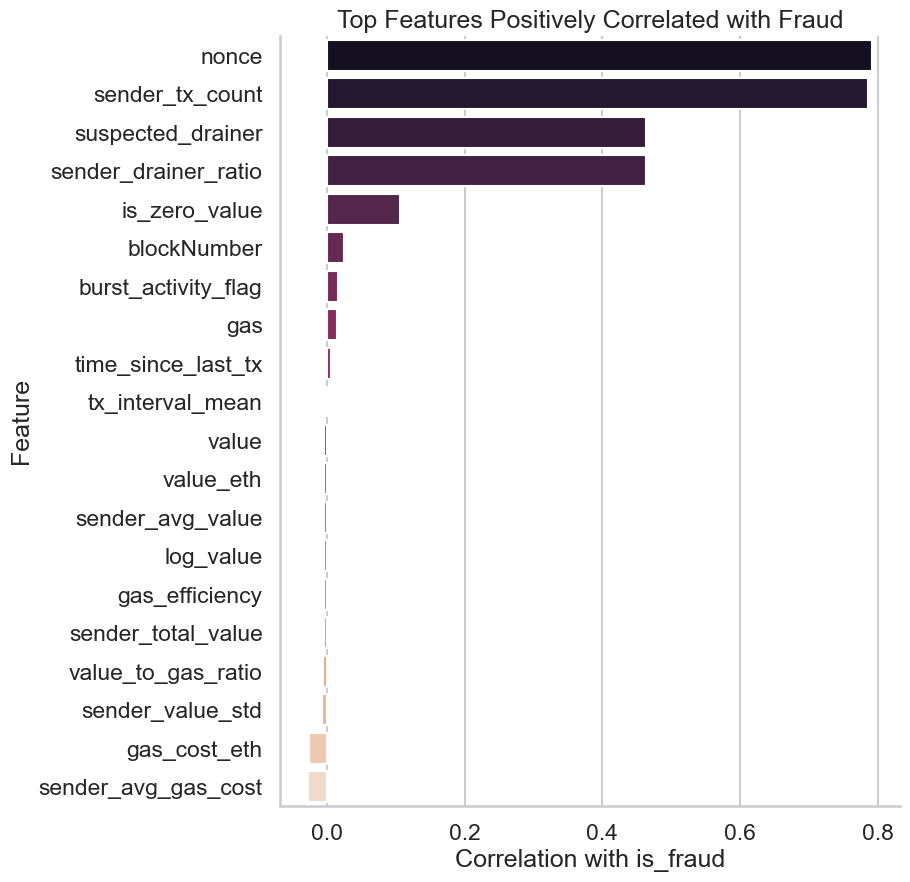

In [86]:
corr = feature_matrix[feature_cols + ['is_fraud']].corr()['is_fraud'].drop('is_fraud').sort_values(ascending=False)
print(corr.head(15))

plt.figure(figsize=(8, 10))
sns.barplot(y=corr.head(20).index, x=corr.head(20).values, palette='rocket')
plt.title('Top Features Positively Correlated with Fraud')
plt.xlabel('Correlation with is_fraud')
plt.ylabel('Feature')
plt.show()


## ✂️ Train/Test Split

In [87]:
tracking_cols = ['hash', 'from', 'to', 'timestamp']
tracking_df = feature_matrix[tracking_cols].set_index('hash')
X = feature_matrix.set_index('hash')[feature_cols]
y = feature_matrix.set_index('hash')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print(f"Train size: {len(X_train):,} | Test size: {len(X_test):,}")
print(f"Fraud rate train: {y_train.mean():.3f} | Fraud rate test: {y_test.mean():.3f}")


Train size: 4,000 | Test size: 1,000
Fraud rate train: 0.063 | Fraud rate test: 0.063


## ⚙️ Modeling Helper

In [88]:
def build_model():
    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        eval_metric='auc',
        tree_method='hist',
        random_state=SEED,
        n_jobs=-1,
    )
    pipeline = ImbPipeline(
        steps=[
            ('smote', SMOTE(random_state=SEED, sampling_strategy=0.35)),
            ('model', xgb),
        ]
    )
    return pipeline

model = build_model()


## 📊 Stratified K-Fold Validation

In [89]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(build_model(), X, y, cv=cv, scoring='roc_auc', n_jobs=1)
print(f"ROC-AUC CV scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


ROC-AUC CV scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.000 ± 0.000


## 🧠 Train Final XGBoost Model

In [90]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"Test ROC-AUC: {roc_auc:.3f}")
print(f"Test PR-AUC : {pr_auc:.3f}")
print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=4))

Test ROC-AUC: 1.000
Test PR-AUC : 1.000

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       937
           1     1.0000    1.0000    1.0000        63

    accuracy                         1.0000      1000
   macro avg     1.0000    1.0000    1.0000      1000
weighted avg     1.0000    1.0000    1.0000      1000



## 🧾 Diagnostic Plots

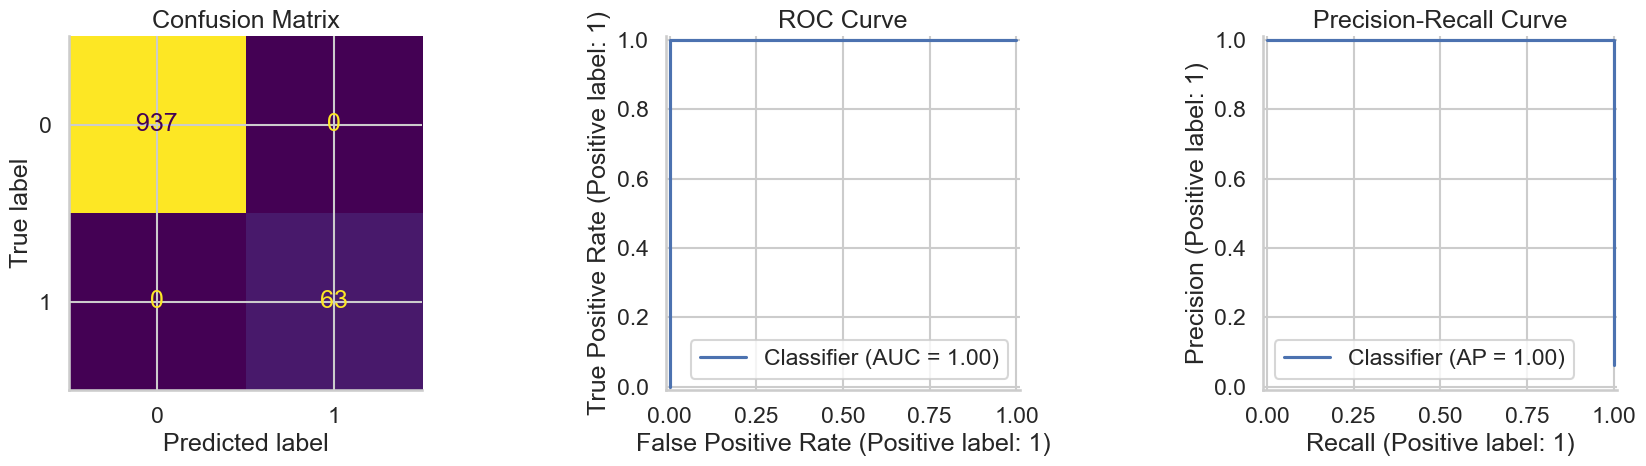

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix')

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].set_title('ROC Curve')

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].set_title('Precision-Recall Curve')
plt.tight_layout()
plt.show()


## 🔍 Feature Importance

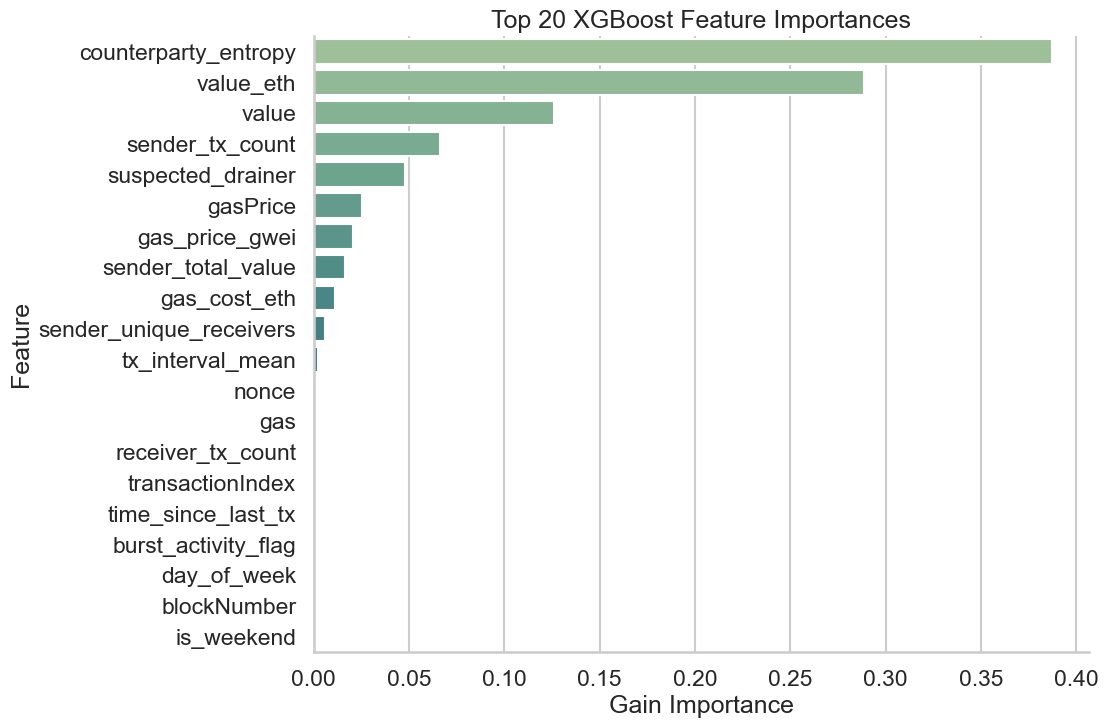

In [92]:
xgb_model = model.named_steps['model']
importances = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importances.head(20), y=importances.head(20).index, palette='crest')
plt.title('Top 20 XGBoost Feature Importances')
plt.xlabel('Gain Importance')
plt.ylabel('Feature')
plt.show()


## ♻️ SHAP Explanations

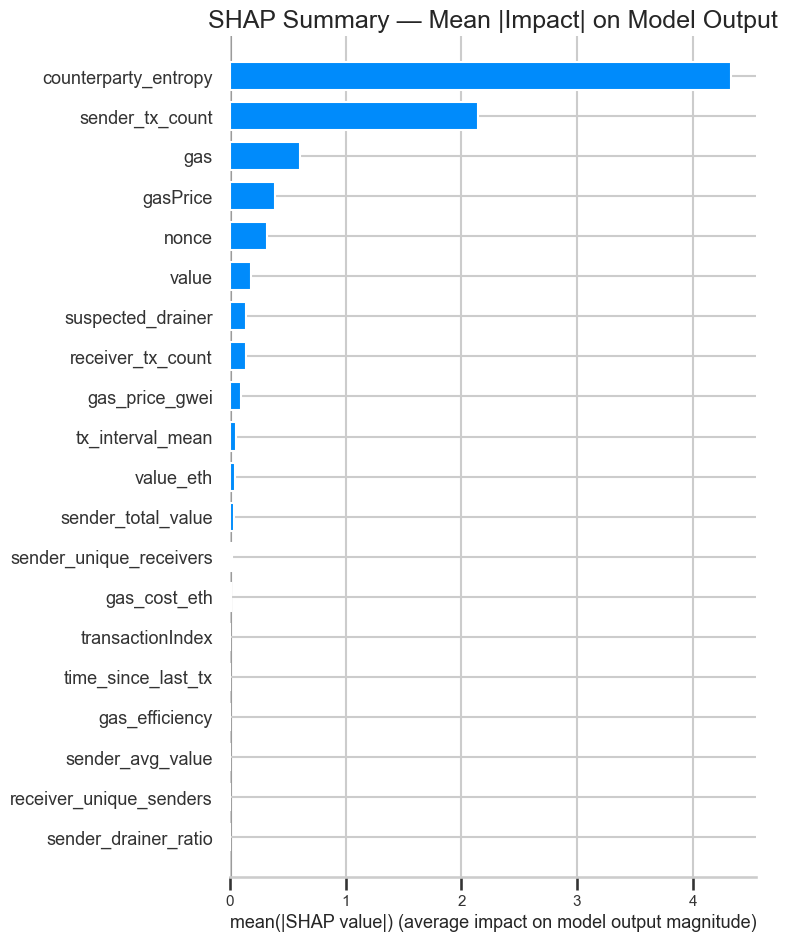

In [93]:
import importlib
import shap.explainers._tree as shap_tree_module
importlib.reload(shap_tree_module)

shap_sample = X_test.sample(n=min(500, len(X_test)), random_state=SEED)

booster = xgb_model.get_booster()
config = json.loads(booster.save_config())
base_score = config.get('learner', {}).get('learner_model_param', {}).get('base_score')
if base_score and base_score.startswith('[') and base_score.endswith(']'):
    clean_score = base_score.strip('[]')
    config['learner']['learner_model_param']['base_score'] = clean_score
    booster.load_config(json.dumps(config))
    xgb_model._Booster = booster

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(shap_sample)

shap.summary_plot(shap_values, shap_sample, plot_type='bar', show=False)
plt.title('SHAP Summary — Mean |Impact| on Model Output')
plt.show()

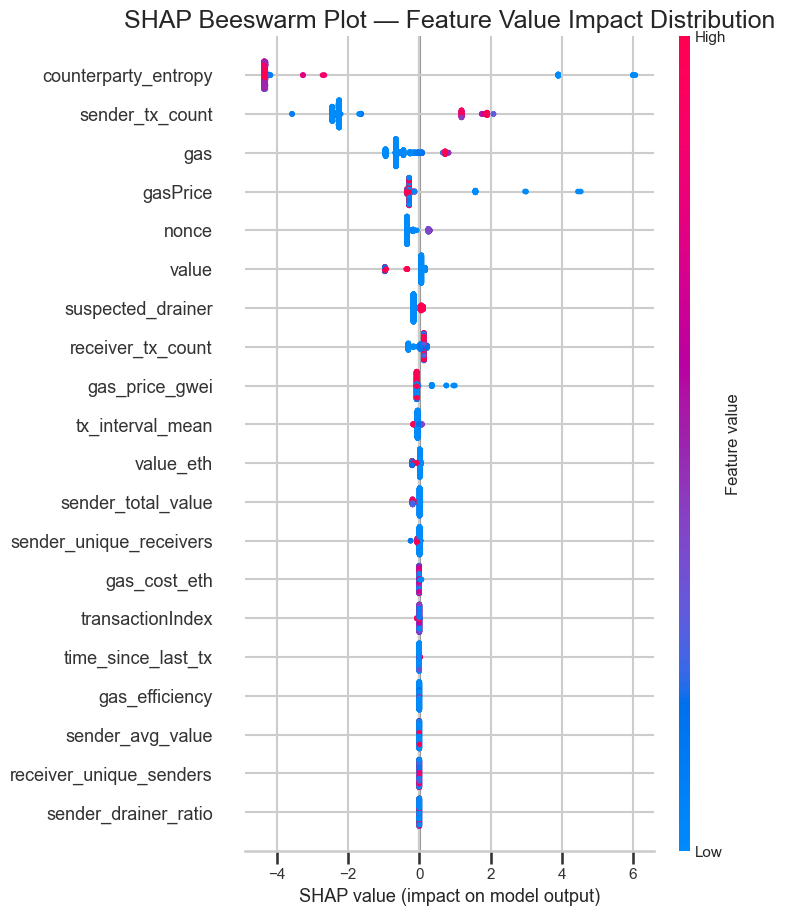

In [94]:
# SHAP Beeswarm Plot (shows feature value impact)
shap.summary_plot(shap_values, shap_sample, show=False)
plt.title('SHAP Beeswarm Plot — Feature Value Impact Distribution')
plt.tight_layout()
plt.show()

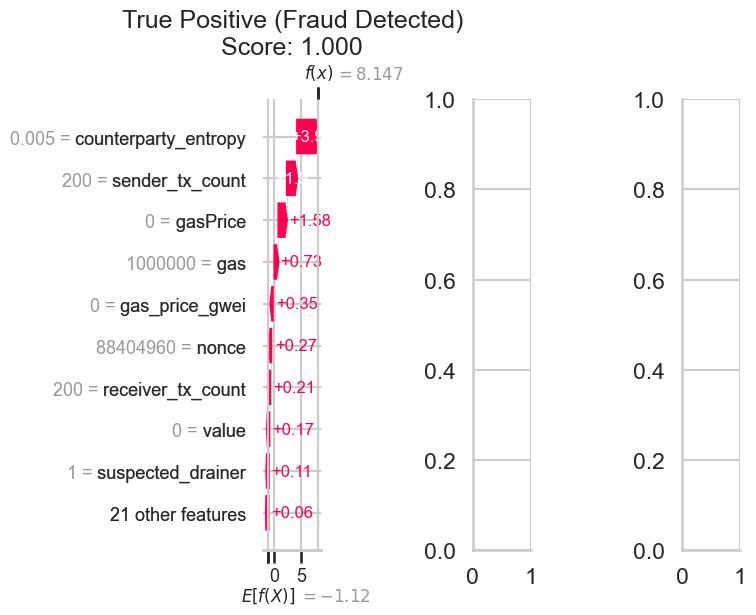

SHAP Base Value (expected model output): -1.1203


In [95]:
# SHAP Waterfall Plot for individual predictions
# Show examples: High-risk fraud, False Positive, False Negative

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Find interesting samples
test_tracking = tracking_df.loc[X_test.index].copy()
test_tracking['fraud_score'] = model.predict_proba(X_test)[:, 1]
test_tracking['prediction'] = model.predict(X_test)
test_tracking['actual'] = y_test

# 1. True Positive (correctly identified fraud)
tp_sample = test_tracking[(test_tracking['prediction'] == 1) & (test_tracking['actual'] == 1)]
if len(tp_sample) > 0:
    tp_idx = tp_sample['fraud_score'].idxmax()
    tp_shap = explainer.shap_values(X_test.loc[[tp_idx]])
    
    plt.subplot(1, 3, 1)
    shap.waterfall_plot(
        shap.Explanation(
            values=tp_shap[0],
            base_values=explainer.expected_value,
            data=X_test.loc[tp_idx].values,
            feature_names=feature_cols
        ),
        show=False
    )
    plt.title(f'True Positive (Fraud Detected)\nScore: {test_tracking.loc[tp_idx, "fraud_score"]:.3f}')

# 2. False Positive (normal flagged as fraud)
fp_sample = test_tracking[(test_tracking['prediction'] == 1) & (test_tracking['actual'] == 0)]
if len(fp_sample) > 0:
    fp_idx = fp_sample['fraud_score'].idxmax()
    fp_shap = explainer.shap_values(X_test.loc[[fp_idx]])
    
    plt.subplot(1, 3, 2)
    shap.waterfall_plot(
        shap.Explanation(
            values=fp_shap[0],
            base_values=explainer.expected_value,
            data=X_test.loc[fp_idx].values,
            feature_names=feature_cols
        ),
        show=False
    )
    plt.title(f'False Positive (Normal but Flagged)\nScore: {test_tracking.loc[fp_idx, "fraud_score"]:.3f}')

# 3. False Negative (fraud missed)
fn_sample = test_tracking[(test_tracking['prediction'] == 0) & (test_tracking['actual'] == 1)]
if len(fn_sample) > 0:
    fn_idx = fn_sample['fraud_score'].idxmin()
    fn_shap = explainer.shap_values(X_test.loc[[fn_idx]])
    
    plt.subplot(1, 3, 3)
    shap.waterfall_plot(
        shap.Explanation(
            values=fn_shap[0],
            base_values=explainer.expected_value,
            data=X_test.loc[fn_idx].values,
            feature_names=feature_cols
        ),
        show=False
    )
    plt.title(f'False Negative (Fraud Missed)\nScore: {test_tracking.loc[fn_idx, "fraud_score"]:.3f}')

plt.tight_layout()
plt.show()

print(f"SHAP Base Value (expected model output): {explainer.expected_value:.4f}")

## 🚨 Top-Risk Addresses (Test Split)

In [96]:
test_tracking = tracking_df.loc[X_test.index].copy()
test_tracking['fraud_score'] = y_proba
test_tracking['prediction'] = y_pred
test_tracking['actual'] = y_test

high_risk = (
    test_tracking.sort_values('fraud_score', ascending=False)
    .head(15)
    .assign(timestamp=lambda df: df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S'))
)
high_risk[['from', 'to', 'timestamp', 'fraud_score', 'prediction', 'actual']]


,from,to,timestamp,fraud_score,prediction,actual
hash,,,,,,
be63d7b31772dc7ab933669fcf3345ad4233f6dbb19939665ef4b860191d0932,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:27,0.999711,1,1
479f3cde404e7839818f2c3757bbf57ba976c2b7b280425a9ea7e6bb9c098962,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:46:24,0.999711,1,1
601d146fa91953bba41aaa19e88e1cce0903d6c76b1653360ff807888ed9e9a9,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:19,0.999711,1,1
ce58d6b46821706afc6d5921ccf85b76b16cbaa6247794cc4d2b38cf82fb3fd3,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:08,0.999711,1,1
57e0d376418f0b85763a7d7e14d820d4bb05055070a41901d9986782dabb3748,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:26,0.999711,1,1
b0f40a37d855cf5e574bf27afc54db53de7c10f782729aed1b2767871bf289e5,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:46:04,0.999711,1,1
da33fcff20c7e92dde262a89d651d01b8a396784f29d38757f69ea4a00547a53,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:14,0.999711,1,1
fd3f56160c81422a5f483e19b3df4efc7136b7af16301b840bb6a765c8ef42a2,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:08,0.999711,1,1
0cbd58972204a526bdd4cb0b8c5aeb5e1955b86f722ccecb706ecde41e751433,0xdeaddeaddeaddeaddeaddeaddeaddeaddead0001,0x4200000000000000000000000000000000000015,2025-11-09 09:45:48,0.999711,1,1


## 💾 Persist the Trained Pipeline

In [97]:
PIPELINE_EXPORT = MODEL_DIR / 'xgb_opbnb_pipeline.pkl'
MODEL_EXPORT = MODEL_DIR / 'xgb_opbnb_native.json'
STANDALONE_EXPORT = MODEL_DIR / 'xgb_opbnb_standalone.pkl'

# Save the full pipeline (with SMOTE)
joblib.dump(model, PIPELINE_EXPORT)
print(f"✅ Saved sklearn/SMOTE pipeline to {PIPELINE_EXPORT}")

# Save the XGBoost model from pipeline (native format)
xgb_model.save_model(MODEL_EXPORT)
print(f"✅ Saved XGBoost booster (from pipeline) to {MODEL_EXPORT}")

# Save standalone XGBoost (for SHAP)
joblib.dump(xgb_standalone, STANDALONE_EXPORT)
print(f"✅ Saved standalone XGBoost (for SHAP) to {STANDALONE_EXPORT}")

# Save feature names for future use
feature_names_file = MODEL_DIR / 'feature_names.txt'
with open(feature_names_file, 'w') as f:
    f.write('\n'.join(feature_cols))
print(f"✅ Saved feature names to {feature_names_file}")

✅ Saved sklearn/SMOTE pipeline to D:\Code\Skripsi_Nopal\models\xgb_opbnb_pipeline.pkl
✅ Saved XGBoost booster (from pipeline) to D:\Code\Skripsi_Nopal\models\xgb_opbnb_native.json
✅ Saved standalone XGBoost (for SHAP) to D:\Code\Skripsi_Nopal\models\xgb_opbnb_standalone.pkl
✅ Saved feature names to D:\Code\Skripsi_Nopal\models\feature_names.txt


## ✅ Wrap-Up
- Cleaned and normalized the latest opBNB snapshot (duplicates removed, timestamps aligned).
- Engineered temporal, behavioral, gas, and counterparty diversity features; persisted them to `data/processed/features_end_to_end.csv`.
- Trained an imbalance-aware XGBoost model with 5-fold CV, plotted diagnostics, and produced SHAP explanations.
- Exported the production-ready pipeline + booster for downstream services or API scoring.

Next natural steps:
1. Plug the saved pipeline into `src/main.py` or create API endpoint for batch scoring or live inference.
2. Augment with on-chain enrichment (token transfers, trace data) to capture more drainer signatures.
3. Schedule automated retraining as new labeled data becomes available.
4. Deploy model monitoring to track performance degradation over time.